<a href="https://colab.research.google.com/github/liuchiente/machine_deep_learning/blob/main/Pycaret_2_1_%E6%87%89%E7%94%A8%E9%80%B2%E8%A1%8C%E6%83%A1%E6%84%8F%E8%BB%9F%E9%AB%94%E5%81%B5%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: 準備環境

1.   不知道為什麼一開始安裝的套件不包含不包含XGBoost,為了包含XGBoost. 所以安裝完全版.
2.   安裝完後,指定pyyaml為5.4.1,然後重新啟動執行環境.



In [ ]:
#為了可以用XGBoost. 所以安裝完全版
!pip install pycaret[full]

In [ ]:
#安裝Yaml後,重新啟動環境,才會生效
!pip install pyyaml==5.4.1

In [ ]:
#連接並mount自己的雲端硬碟(點選跑出網址複製最後的授權碼貼上並執行)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#切換到作業3指定目錄
SYS_DIR = "/content/drive/My Drive/Colab Notebooks/HW#3/"

In [ ]:
import os
if os.path.isdir(SYS_DIR) is False:
  os.mkdir(SYS_DIR)
os.chdir(SYS_DIR)

#**惡意軟體偵測**

##Step 1: Load data (also import library)

In [ ]:
#確認目錄下資料狀況
!ls

best_5566.eval.pkl     MalwareArtifacts.csv		 rf_5566.eval.pkl
best_5566.pkl	       network-logs.csv			 rf_5566.pkl
catboost_info	       phishing_dataset.csv		 test.csv
gender_submission.csv  Phishing_Legitimate_full.csv	 titanic.zip
logs.log	       Phishing_Legitimate_full.csv.zip  train.csv


In [ ]:
#引入套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
#載入資料,惡意軟體偵測,MalwareArtifacts.csv
dataset_ma=pd.read_csv('MalwareArtifacts.csv')
dataset_ma.head()

##Step 2: Pre-processing (missing data, categorical type, normalization, format transform)
1.   欄位legitimate是惡意軟體的識別,也就是Y



In [ ]:
#因為只有一份資料,在這裡我們切分出訓練、測試資料,各佔佔80%、20%
train_data_ma, test_data_ma = train_test_split(dataset_ma, random_state=123, train_size=0.8)
train_data_ma.head()

##Step 2-2: Pre-processing , 為了改善效能, 移除一些不必要的特徵

In [ ]:
#MajorLinkerVersion、MajorImageVersion都是在開發時由工程師指定的版本號碼,感覺沒啥意義,所以先刪除
train_data_mal=train_data_ma.drop(['MajorImageVersion', 'MajorLinkerVersion'], axis=1)
test_data_mal=test_data_ma.drop(['MajorImageVersion', 'MajorLinkerVersion'], axis=1)

train_data_mal.head()
test_data_mal.head()

,AddressOfEntryPoint,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate
3634,54719,6,320,262144,4,84522,1
30532,4112,6,320,262144,7,126480,1
20796,4823,4,320,1048576,5,14926,1
85616,1401936,4,0,1048576,3,0,0
87987,55234,4,34112,1048576,3,612,0


# Step 3: Build Model for training

## Step 3.1: AutoML


1.   使用compare_models可以比較出各演算法的表現,在這裡指定找出表現最佳的15個演算法.
2.   Accuracy最高的是Random Forest Classifier,不過AUC分數比較高的反而是XGBoost,可見XGBoost的分類能力,不過因為差距很小,所以依然認定Random Forest Classifier較佳.



In [ ]:
#設定訓練環境
from pycaret.classification import *
clf_ma_al = setup(data = train_data_mal,target='legitimate')

In [ ]:
#使用 compare_models() 來比較個演算法的表現，找出最佳的15個模型，以切 5 fold
top15model=compare_models(fold = 5,n_select = 15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9887,0.9985,0.9830,0.9792,0.9811,0.9730,0.9730,5.692
et,Extra Trees Classifier,0.9870,0.9977,0.9797,0.9768,0.9782,0.9690,0.9690,3.630
xgboost,Extreme Gradient Boosting,0.9869,0.9987,0.9784,0.9775,0.9779,0.9686,0.9686,13.540
catboost,CatBoost Classifier,0.9868,0.9986,0.9780,0.9776,0.9778,0.9684,0.9684,19.664
lightgbm,Light Gradient Boosting Machine,0.9853,0.9985,0.9762,0.9744,0.9753,0.9648,0.9648,0.802
dt,Decision Tree Classifier,0.9841,0.9817,0.9746,0.9721,0.9734,0.9620,0.9620,0.236
gbc,Gradient Boosting Classifier,0.9803,0.9962,0.9637,0.9700,0.9668,0.9528,0.9528,8.430
ada,Ada Boost Classifier,0.9701,0.9941,0.9295,0.9688,0.9487,0.9276,0.9280,2.852
knn,K Neighbors Classifier,0.9658,0.9884,0.9497,0.9365,0.9431,0.9186,0.9187,4.076
lda,Linear Discriminant Analysis,0.9059,0.9701,0.7811,0.8906,0.8319,0.7670,0.7705,0.434


In [ ]:
#用AutoML找出最好的Model
best_model = automl(optimize = 'Accuracy')

In [ ]:
#觀察預測結果
pred_best = predict_model(best_model,data = test_data_mal)
pred_best.head()

,AddressOfEntryPoint,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,Label,Score
3634,54719,6,320,262144,4,84522,1,1,1.00
30532,4112,6,320,262144,7,126480,1,1,1.00
20796,4823,4,320,1048576,5,14926,1,1,1.00
85616,1401936,4,0,1048576,3,0,0,0,1.00
87987,55234,4,34112,1048576,3,612,0,0,0.99


In [ ]:
#看一下測試資料的 accuracy
from sklearn.metrics import accuracy_score
accuracy_score(pred_best['legitimate'],pred_best['Label'])

0.9890137873331151

In [ ]:
#儲存模型
save_model(pred_best,'best_5566.eval')
save_model(best_model,'best_5566')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='legitimate', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_s...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                         max_l

# Step 4: Evalute Model

##Step 4-1: 評估特徵、演算法等

In [ ]:
#因為只有一份資料,在這裡我們切分出訓練、測試資料,各佔佔80%、20%
train_data, test_data = train_test_split(dataset_ma, random_state=123, train_size=0.8)
train_data.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate
105940,40000,2,0,1,0,1048576,8,9640,0
122638,24735,11,0,5,33088,1048576,3,534528,0
118698,61562,10,0,5,33088,1048576,5,9640,0
70111,67835,11,0,5,33024,1048576,4,3752,0
13541,44500,9,6,6,320,262144,5,920,1


In [ ]:
#比較一下,如果全部的欄位都加入訓練,評估的結果如何
from pycaret.classification import *
clf_mall = setup(data = train_data,target='legitimate')

,Description,Value
0,session_id,4999
1,Target,legitimate
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(109955, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
#使用 compare_models() 來比較個演算法的表現，找出最佳的15個模型，以切 5 fold
top15model=compare_models(fold = 5,n_select = 15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9899,0.9988,0.9836,0.9825,0.9830,0.9759,0.9759,7.008
et,Extra Trees Classifier,0.9891,0.9979,0.9824,0.9808,0.9816,0.9738,0.9738,3.976
catboost,CatBoost Classifier,0.9885,0.9989,0.9802,0.9808,0.9805,0.9723,0.9723,19.710
xgboost,Extreme Gradient Boosting,0.9883,0.9990,0.9810,0.9794,0.9802,0.9718,0.9719,8.738
lightgbm,Light Gradient Boosting Machine,0.9869,0.9988,0.9779,0.9780,0.9779,0.9686,0.9686,0.866
dt,Decision Tree Classifier,0.9855,0.9829,0.9758,0.9750,0.9754,0.9651,0.9651,0.426
gbc,Gradient Boosting Classifier,0.9817,0.9971,0.9613,0.9763,0.9687,0.9558,0.9558,5.592
ada,Ada Boost Classifier,0.9717,0.9952,0.9390,0.9645,0.9516,0.9316,0.9318,1.924
knn,K Neighbors Classifier,0.9664,0.9883,0.9500,0.9373,0.9436,0.9197,0.9197,4.786
lda,Linear Discriminant Analysis,0.9068,0.9705,0.7734,0.8978,0.8308,0.7670,0.7712,0.284


In [ ]:
#用AutoML找出最好的Model
best_model_all = automl(optimize = 'Accuracy')

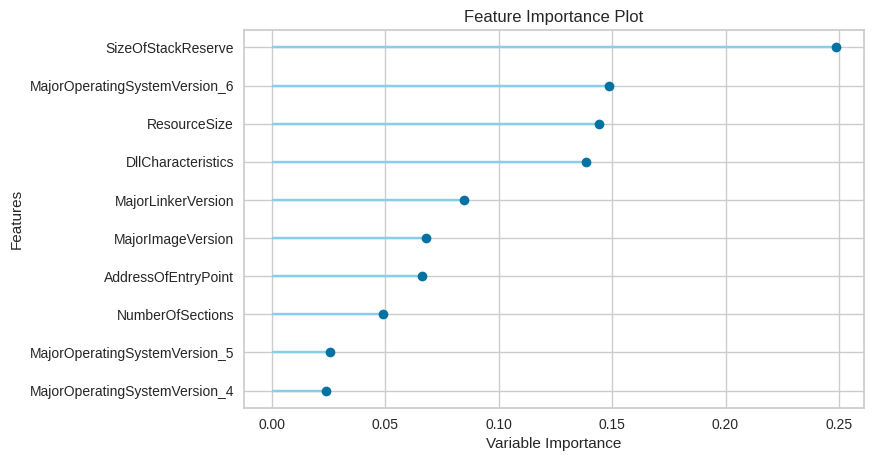

In [ ]:
#觀察這些特徵的重要性
plot_model(best_model_all,'feature')

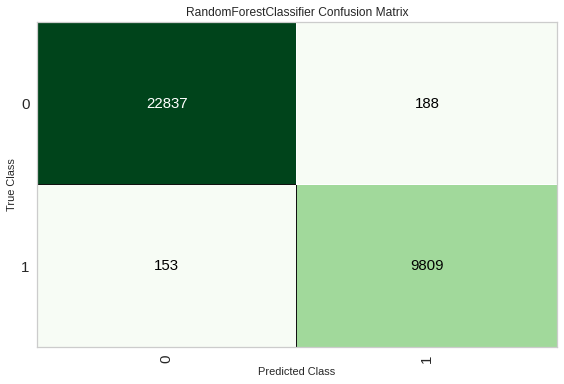

In [ ]:
#觀察混淆矩陣的狀況
plot_model(best_model_all,'confusion_matrix')

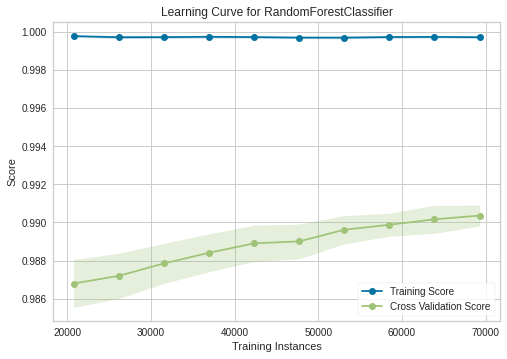

In [ ]:
#觀察學習曲線
plot_model(best_model_all,'learning')

In [ ]:
interpret_model(best_model)

In [ ]:
#觀察Compaer比較結果, 發現Random Forest Classifier的Accuracy最高, Acc也最高, 所以用rf呼叫一個model,來測試看看
rf_model = create_model('rf')
pred_rf = predict_model(rf_model,data = test_data)
pred_rf.head()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9901,0.9990,0.9859,0.9808,0.9834,0.9763,0.9763
1,0.9901,0.9987,0.9868,0.9799,0.9834,0.9763,0.9764
2,0.9895,0.9986,0.9794,0.9850,0.9822,0.9747,0.9747
3,0.9909,0.9988,0.9838,0.9855,0.9846,0.9782,0.9782
4,0.9905,0.9986,0.9842,0.9838,0.9840,0.9772,0.9772
5,0.9909,0.9994,0.9846,0.9846,0.9846,0.9782,0.9782
6,0.9896,0.9988,0.9842,0.9807,0.9825,0.9751,0.9751
7,0.9901,0.9992,0.9837,0.9829,0.9833,0.9763,0.9763
8,0.9908,0.9993,0.9868,0.9821,0.9844,0.9779,0.9779
9,0.9912,0.9991,0.9864,0.9838,0.9851,0.9788,0.9788


,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,Label,Score
3634,54719,9,6,6,320,262144,4,84522,1,1,1.0
30532,4112,9,6,6,320,262144,7,126480,1,1,1.0
20796,4823,8,0,4,320,1048576,5,14926,1,1,1.0
85616,1401936,2,0,4,0,1048576,3,0,0,0,1.0
87987,55234,8,0,4,34112,1048576,3,612,0,0,1.0


In [ ]:
#看一下測試資料的 accuracy,發現已經頗高
accuracy_score(pred_rf['legitimate'],pred_rf['Label'])

0.9906508057768562

In [ ]:
#儲存模型
save_model(pred_rf,'rf_5566.eval')
save_model(rf_model,'rf_5566')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='legitimate', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_s...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                         max_l

# Step 4.2: HPO

In [ ]:
from pycaret.classification import * 
# 使用資料集來做Model的改善
clf1_hpo = setup(data = dataset_ma, target = 'legitimate')
# 建立一個決策樹Model
dt_model = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9862,0.9842,0.9770,0.9766,0.9768,0.9669,0.9669
1,0.9874,0.9851,0.9794,0.9784,0.9789,0.9699,0.9699
2,0.9867,0.9847,0.9798,0.9757,0.9777,0.9682,0.9682
3,0.9880,0.9864,0.9818,0.9781,0.9800,0.9715,0.9715
4,0.9861,0.9833,0.9759,0.9773,0.9766,0.9667,0.9667
5,0.9858,0.9835,0.9773,0.9749,0.9761,0.9660,0.9660
6,0.9876,0.9857,0.9805,0.9781,0.9793,0.9704,0.9704
7,0.9880,0.9860,0.9812,0.9788,0.9800,0.9714,0.9714
8,0.9876,0.9858,0.9808,0.9777,0.9793,0.9704,0.9704
9,0.9864,0.9840,0.9784,0.9760,0.9772,0.9675,0.9675


In [ ]:
# 觀察沒有經過改善的預測結果
pred_dt = predict_model(dt_model,data = test_data)
pred_dt.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,Label,Score
3634,54719,9,6,6,320,262144,4,84522,1,1,1.0
30532,4112,9,6,6,320,262144,7,126480,1,1,1.0
20796,4823,8,0,4,320,1048576,5,14926,1,1,1.0
85616,1401936,2,0,4,0,1048576,3,0,0,0,1.0
87987,55234,8,0,4,34112,1048576,3,612,0,0,1.0


In [ ]:
#看一下測試資料的 accuracy
accuracy_score(pred_dt['legitimate'],pred_dt['Label'])

0.9962530466732148

In [ ]:
# 改善決策樹
tuned_dt_model = tune_model(dt_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9762,0.9857,0.9606,0.9596,0.9601,0.9431,0.9431
1,0.9762,0.9864,0.9550,0.9647,0.9598,0.9429,0.9429
2,0.9744,0.9862,0.9599,0.9545,0.9572,0.9390,0.9390
3,0.9750,0.9849,0.9560,0.9597,0.9579,0.9400,0.9400
4,0.9731,0.9856,0.9557,0.9540,0.9548,0.9357,0.9357
5,0.9766,0.9870,0.9595,0.9619,0.9607,0.9440,0.9440
6,0.9774,0.9889,0.9647,0.9597,0.9622,0.9462,0.9462
7,0.9744,0.9862,0.9585,0.9558,0.9571,0.9389,0.9389
8,0.9739,0.9868,0.9550,0.9573,0.9561,0.9376,0.9376
9,0.9754,0.9883,0.9605,0.9569,0.9587,0.9412,0.9412


In [ ]:
# 觀察改善後的預測結果
pred_dt_tuned = predict_model(tuned_dt_model,data = test_data)
pred_dt_tuned.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,Label,Score
3634,54719,9,6,6,320,262144,4,84522,1,1,0.9890
30532,4112,9,6,6,320,262144,7,126480,1,1,0.9890
20796,4823,8,0,4,320,1048576,5,14926,1,1,0.6891
85616,1401936,2,0,4,0,1048576,3,0,0,0,0.9170
87987,55234,8,0,4,34112,1048576,3,612,0,0,0.8618


In [ ]:
#看一下改善後的預測 accuracy
accuracy_score(pred_dt_tuned['legitimate'],pred_dt_tuned['Label'])

0.9754083451562443

In [ ]:
# 一次改善50次
tuned_dt_50model = tune_model(tuned_dt_model, n_iter = 50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9858,0.9960,0.9756,0.9766,0.9761,0.9659,0.9659
1,0.9844,0.9953,0.9724,0.9751,0.9738,0.9627,0.9627
2,0.9849,0.9937,0.9773,0.9722,0.9748,0.9640,0.9640
3,0.9848,0.9945,0.9710,0.9779,0.9744,0.9636,0.9637
4,0.9811,0.9921,0.9672,0.9692,0.9682,0.9547,0.9547
5,0.9846,0.9942,0.9714,0.9768,0.9741,0.9632,0.9632
6,0.9858,0.9962,0.9752,0.9769,0.9761,0.9659,0.9659
7,0.9845,0.9930,0.9759,0.9722,0.9740,0.9630,0.9630
8,0.9852,0.9939,0.9731,0.9772,0.9752,0.9647,0.9647
9,0.9847,0.9948,0.9756,0.9732,0.9744,0.9635,0.9635


In [ ]:
# 觀察改善50次後的預測結果
pred_dt_tuned_50 = predict_model(tuned_dt_50model,data = test_data)
pred_dt_tuned_50.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,Label,Score
3634,54719,9,6,6,320,262144,4,84522,1,1,0.9997
30532,4112,9,6,6,320,262144,7,126480,1,1,1.0000
20796,4823,8,0,4,320,1048576,5,14926,1,1,0.7076
85616,1401936,2,0,4,0,1048576,3,0,0,0,1.0000
87987,55234,8,0,4,34112,1048576,3,612,0,0,0.9939


In [ ]:
#看一下改善後的預測 accuracy
accuracy_score(pred_dt_tuned_50['legitimate'],pred_dt_tuned_50['Label'])

0.9875222816399287

In [ ]:
# 設定一下相關參數, 再做一次改善
params = {"max_depth": np.random.randint(1, (len(dataset_ma.columns)*.85),20),
          "max_features": np.random.randint(1, len(dataset_ma.columns),20),
          "min_samples_leaf": [2,3,4,5,6],
          "criterion": ["gini", "entropy"]
          }
tuned_dt_custom = tune_model(dt, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9730,0.9896,0.9557,0.9537,0.9547,0.9354,0.9354
1,0.9742,0.9913,0.9501,0.9629,0.9564,0.9381,0.9382
2,0.9683,0.9884,0.9480,0.9457,0.9468,0.9243,0.9243
3,0.9755,0.9907,0.9539,0.9633,0.9586,0.9412,0.9412
4,0.9680,0.9909,0.9281,0.9631,0.9453,0.9226,0.9230
5,0.9757,0.9906,0.9557,0.9624,0.9590,0.9417,0.9417
6,0.9790,0.9914,0.9682,0.9615,0.9649,0.9499,0.9499
7,0.9747,0.9913,0.9567,0.9584,0.9576,0.9396,0.9396
8,0.9709,0.9872,0.9354,0.9658,0.9503,0.9298,0.9300
9,0.9653,0.9896,0.9651,0.9219,0.9430,0.9181,0.9186


In [ ]:
# 觀察改善相關參數後的預測結果
pred_dt_tuned_cust = predict_model(tuned_dt_custom,data = test_data)
pred_dt_tuned_cust.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate,Label,Score
3634,54719,9,6,6,320,262144,4,84522,1,1,0.9975
30532,4112,9,6,6,320,262144,7,126480,1,1,0.9975
20796,4823,8,0,4,320,1048576,5,14926,1,1,0.7776
85616,1401936,2,0,4,0,1048576,3,0,0,0,0.8823
87987,55234,8,0,4,34112,1048576,3,612,0,0,0.7873


In [ ]:
#看一下改善後的預測 accuracy
accuracy_score(pred_dt_tuned_cust['legitimate'],pred_dt_tuned_cust['Label'])

0.9743533777147223

#Step 4-3: Stack model

In [ ]:
#因為只有一份資料,在這裡我們切分出訓練、測試資料,各佔佔80%、20%
train_data, test_data = train_test_split(dataset_ma, random_state=123, train_size=0.8)
train_data.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate
105940,40000,2,0,1,0,1048576,8,9640,0
122638,24735,11,0,5,33088,1048576,3,534528,0
118698,61562,10,0,5,33088,1048576,5,9640,0
70111,67835,11,0,5,33024,1048576,4,3752,0
13541,44500,9,6,6,320,262144,5,920,1


In [ ]:
#比較一下,如果全部的欄位都加入訓練,評估的結果如何
from pycaret.classification import *
clf_ma_st = setup(data = train_data,target='legitimate')

,Description,Value
0,session_id,8090
1,Target,legitimate
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(109955, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# 比較一下大家一起上,用5種去做訓練
# 省時間全部fold切5分
dt = create_model('dt', fold = 5)
svm = create_model('svm', fold = 5)
rbfsvm = create_model('rbfsvm', fold = 5)
gpc = create_model('gpc', fold = 5)
mlp = create_model('mlp', fold = 5)
#ridge = create_model('ridge', fold = 5)
#rf = create_model('rf', fold = 5)
#qda = create_model('qda', fold = 5)
#ada = create_model('ada', fold = 5)
#lda = create_model('lda', fold = 5)
#gbc = create_model('gbc', fold = 5)
#et = create_model('et', fold = 5)
#xgboost = create_model('xgboost', fold = 5)
#lightgbm = create_model('lightgbm', fold = 5)
#catboost = create_model('catboost', fold = 5)

# 第二層用亂度森林
stacker_alls = stack_models(estimator_list = [dt,svm,rbfsvm,gpc,mlp], meta_model = rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9418,0.9828,0.9993,0.8367,0.9108,0.8681,0.8757
1,0.9380,0.9820,0.9983,0.8285,0.9055,0.8600,0.8683
2,0.9407,0.9828,0.9993,0.8341,0.9093,0.8658,0.8736
3,0.9426,0.9836,0.9989,0.8388,0.9119,0.8698,0.8771
4,0.9430,0.9840,1.0000,0.8392,0.9126,0.8708,0.8782
Mean,0.9412,0.9830,0.9992,0.8355,0.9100,0.8669,0.8745
SD,0.0018,0.0007,0.0006,0.0039,0.0025,0.0038,0.0035


IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:57:42
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gaussian Process Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


tcmalloc: large alloc 30330863616 bytes == 0x55779449c000 @  0x7f23fc5d71e7 0x7f23f2dce46e 0x7f23f2e1ec7b 0x7f23f2e1f35f 0x7f23f2ec1103 0x5577782c54b0 0x5577782c5240 0x557778338973 0x5577783339ee 0x5577782c6bda 0x557778335737 0x5577783339ee 0x5577782c7271 0x55777830a409 0x5577782c5c52 0x5577783394d9 0x5577783339ee 0x5577782c7271 0x55777830a409 0x5577782c5c52 0x557778338c25 0x5577783339ee 0x5577782c6bda 0x557778334c0d 0x557778333ced 0x5577782c6bda 0x557778334c0d 0x5577782c7039 0x5577782c7698 0x557778335fe4 0x5577783339ee


In [ ]:
#看一下測試資料的 accuracy
pred = predict_model(stacker_alls,data = test_data)
accuracy_score(pred['legitimate'],pred['Label'])

In [ ]:
#儲存模型
save_model(stacker_all,'stacker_55666')

In [ ]:
model = load_model('stacker_55666')
pred = predict_model(model,data = test_data)

pred.head()

In [ ]:
# 第二層用亂度森林
rf = create_model('rf', fold = 5)
stacker_alls_best15 = stack_models(estimator_list = top3model, meta_model = rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9904,0.9991,0.9830,0.9847,0.9838,0.9770,0.9770
1,0.9908,0.9995,0.9843,0.9847,0.9845,0.9779,0.9779
2,0.9904,0.9988,0.9834,0.9843,0.9838,0.9770,0.9770
3,0.9910,0.9980,0.9895,0.9805,0.9850,0.9786,0.9786
4,0.9899,0.9989,0.9821,0.9838,0.9830,0.9758,0.9758
5,0.9901,0.9989,0.9873,0.9797,0.9835,0.9764,0.9765
6,0.9921,0.9991,0.9891,0.9844,0.9867,0.9811,0.9811
7,0.9883,0.9983,0.9817,0.9791,0.9804,0.9721,0.9721
8,0.9917,0.9986,0.9839,0.9882,0.9860,0.9801,0.9801
9,0.9913,0.9994,0.9869,0.9839,0.9854,0.9792,0.9792


In [ ]:
#看一下測試資料的 accuracy
pred = predict_model(stacker_alls_best15,data = test_data)
accuracy_score(pred['legitimate'],pred['Label'])

0.990432536651024

#惡意軟體偵測(亂度森林)

##Step 1: Load data (also import library)

In [ ]:
#載入資料
datasetm=pd.read_csv('MalwareArtifacts.csv')
datasetm.head()

,AddressOfEntryPoint,MajorLinkerVersion,MajorImageVersion,MajorOperatingSystemVersion,DllCharacteristics,SizeOfStackReserve,NumberOfSections,ResourceSize,legitimate
0,10407,9,6,6,33088,262144,4,952,1
1,5354,9,6,6,33088,262144,4,952,1
2,58807,9,6,6,33088,262144,4,136490,1
3,25166,9,6,6,33088,262144,4,1940,1
4,70387,9,6,6,33088,262144,4,83098,1


# Step 2: Pre-process X, Y

In [ ]:
samples = datasetm.iloc[:, [0,4]].values
targets = datasetm.iloc[:, 8].values

In [ ]:
from sklearn.model_selection import train_test_split

training_samples, testing_samples, training_targets, testing_targets = train_test_split(samples, targets, test_size=0.2)

# Step 3: Build Model for training

In [ ]:
rfc =  ensemble.RandomForestClassifier(n_estimators=50)
rfc.fit(training_samples, training_targets)
accuracy = rfc.score(testing_samples, testing_targets)

print("Random Forest Classifier accuracy: " + str(accuracy*100) )

Random Forest Classifier accuracy: 96.4349376114082


# Step 4: Evalute Model

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(datasetm, random_state=777, train_size=0.8)
#training_samples, testing_samples, training_targets, testing_targets = train_test_split(datasetm, random_state=777, train_size=0.8)

## Step 1: Load data (also import library)＿鐵達尼乘客存活預測

In [ ]:
#引入套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#解壓縮檔案
!unzip titanic.zip 

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!ls

gender_submission.csv  phishing_dataset.csv  test.csv  titanic.zip  train.csv


In [ ]:
#加載資料集
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#Step 1.1: 附上各欄位的說明, 用來分辨特徵

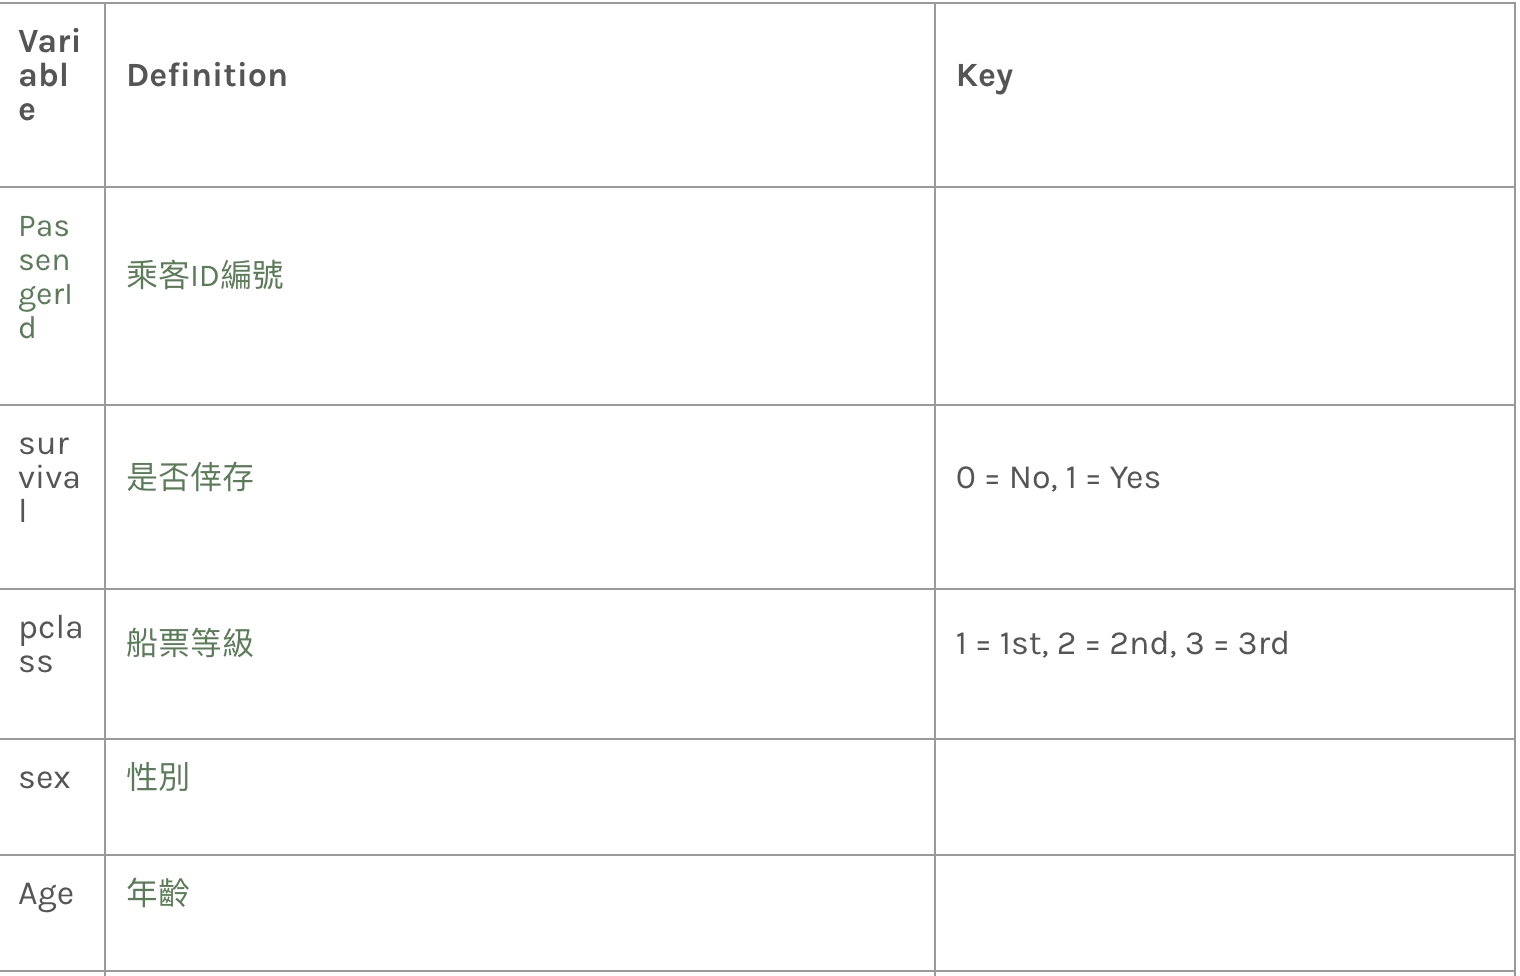

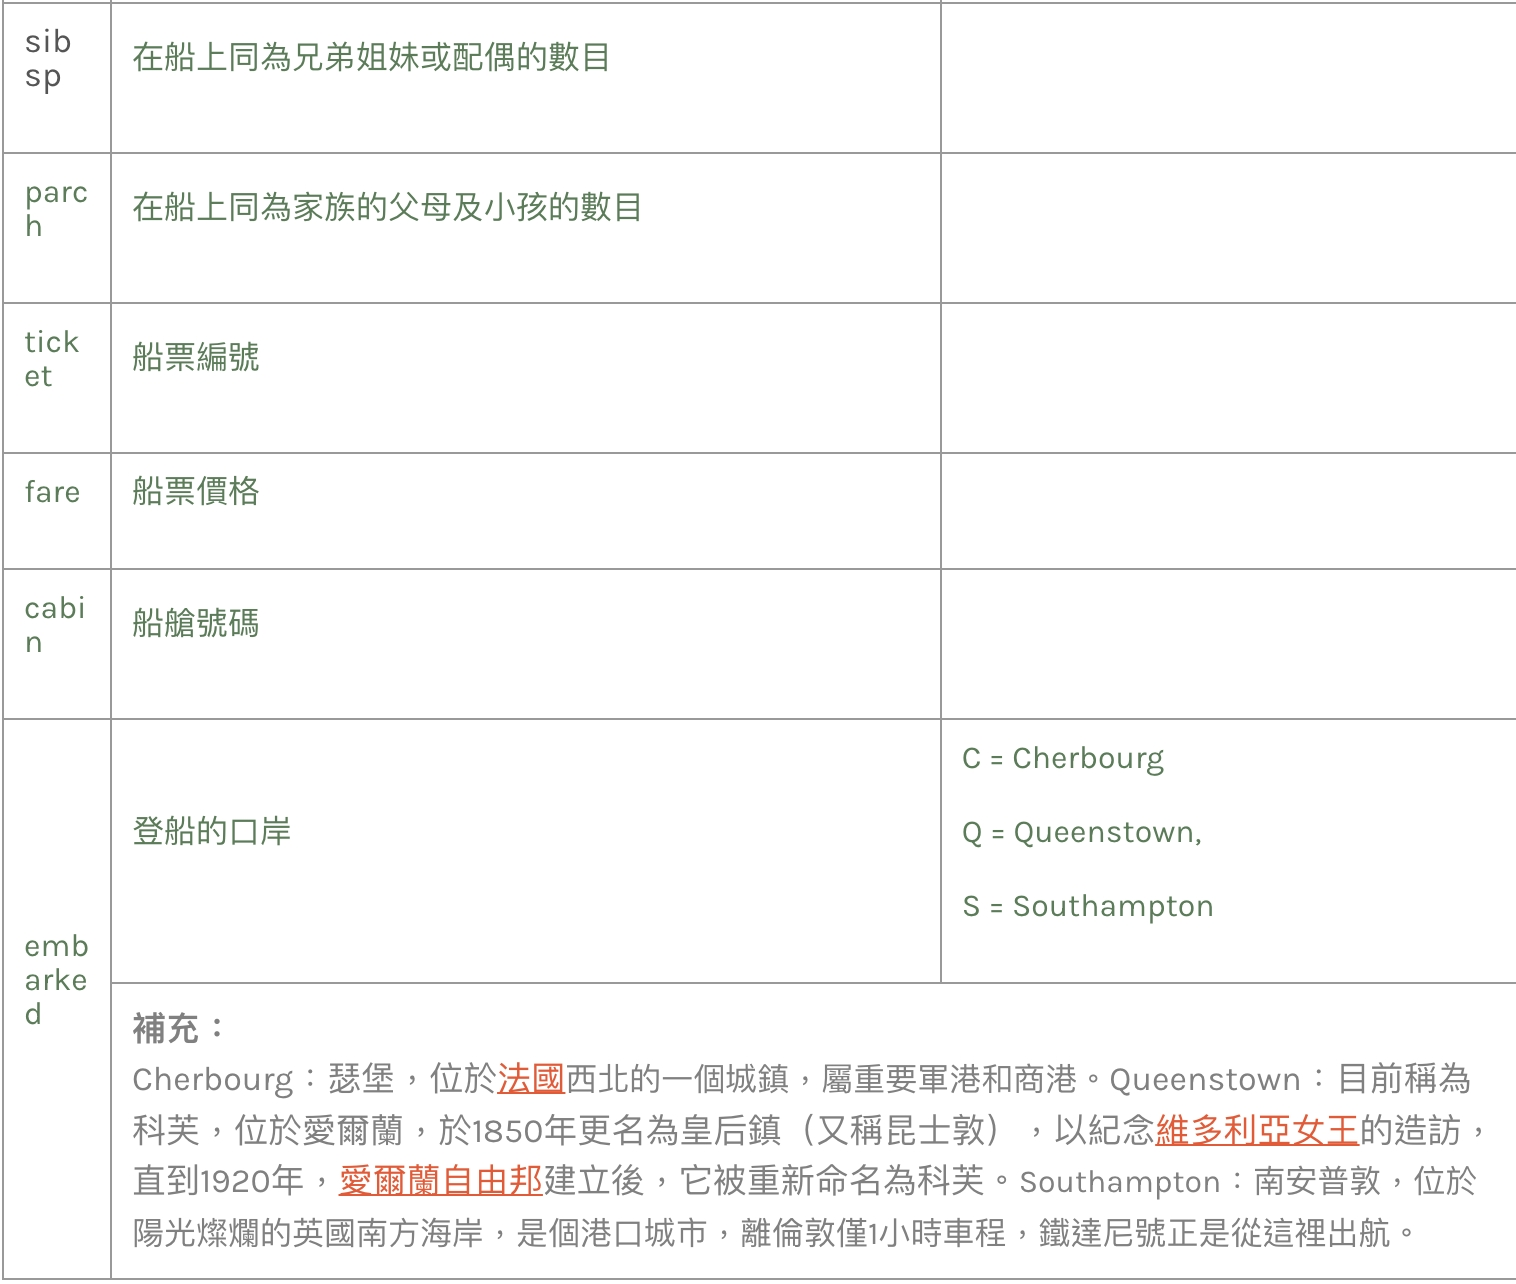

# Step 2: Pre-process X, Y

In [ ]:
#用年齡分群
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

#用艙別分群
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

#用票價分群
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

#把姓名的 Mr. Ms. 稱謂分離出來當特徵
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    

#刪掉 Ticket、Name感覺沒有用的欄位    
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1)

#重新整理特徵, 原本的做法是用年紀、艙別、票價和姓名來做特徵, 但我觀察欄位說明後, 票的等級和出發地應該影響會更大, 畢竟有某種程度的種姓關係？
#另外把稱謂移出特徵, 在男性方面,Mrs.和Miss應該沒有太大的死亡率差別, 最後保留用出發地Embarked當特徵
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    #df = format_name(df)
    df = drop_features(df)
    return df

#整理訓練、測試資料
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,Student,1,0,1_quartile,N,S
1,2,1,1,female,Adult,1,0,4_quartile,C,C
2,3,1,3,female,Young Adult,0,0,1_quartile,N,S
3,4,1,1,female,Young Adult,1,0,4_quartile,C,S
4,5,0,3,male,Young Adult,0,0,2_quartile,N,S


In [ ]:
#切訓練資料的 20% 作為模型驗證資料
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_train.drop(['PassengerId'], axis=1), random_state=100, train_size=0.8)

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
408,0,3,male,Student,0,0,1_quartile,N,S
480,0,3,male,Child,5,2,4_quartile,N,S
510,1,3,male,Young Adult,0,0,1_quartile,N,Q
609,1,1,female,Adult,0,0,4_quartile,C,S
547,1,2,male,Unknown,0,0,2_quartile,N,C


# Step 3: Build Model for training

In [ ]:
#設定訓練環境，可以看到他可以指定類別變數，減去 Encoding 的流程
from pycaret.classification import *

clf1 = setup(data = train_data, 
             target = 'Survived', 
             categorical_features = ['Pclass','Sex','Age','Fare','Cabin','Embarked'])

,Description,Value
0,session_id,5318
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(712, 9)"
5,Missing Values,True
6,Numeric Features,0
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


# Step 4: Evalute Model

In [ ]:
#使用 compare_models() 來比較個演算法的表現，找出最佳的模型，以切 5 fold
compare_models(fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8092,0.8347,0.6718,0.7977,0.7263,0.5820,0.5895,0.094
ridge,Ridge Classifier,0.8052,0.0000,0.7250,0.7545,0.7379,0.5833,0.5851,0.016
lr,Logistic Regression,0.8032,0.8427,0.7040,0.7625,0.7294,0.5757,0.5791,0.640
lda,Linear Discriminant Analysis,0.8032,0.8387,0.7250,0.7509,0.7359,0.5794,0.5815,0.020
gbc,Gradient Boosting Classifier,0.8031,0.8323,0.6824,0.7761,0.7233,0.5719,0.5772,0.096
xgboost,Extreme Gradient Boosting,0.7971,0.8374,0.7037,0.7511,0.7238,0.5642,0.5676,3.166
ada,Ada Boost Classifier,0.7912,0.8275,0.7091,0.7346,0.7189,0.5533,0.5560,0.108
catboost,CatBoost Classifier,0.7912,0.8458,0.6189,0.7924,0.6915,0.5377,0.5496,1.000
rf,Random Forest Classifier,0.7771,0.8219,0.6401,0.7451,0.6854,0.5146,0.5208,0.566
et,Extra Trees Classifier,0.7770,0.7828,0.6558,0.7365,0.6908,0.5175,0.5224,0.542


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5318, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#Step 4-1: Stack model

觀察一下, 上述Light Gradient Boosting Machine

#Step 4-1: Stack model

In [ ]:
ridge = create_model('ridge')
lda = create_model('lda')
gbc = create_model('gbc')
lr = create_model('lr')

stacker = stack_models(estimator_list = [ridge,lda,gbc], meta_model = lr)
stacker

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7800,0.8559,0.5556,0.7692,0.6452,0.4917,0.5054
1,0.7000,0.7674,0.6111,0.5789,0.5946,0.3568,0.3571
2,0.8600,0.8516,0.6667,0.9231,0.7742,0.6765,0.6953
3,0.8000,0.8368,0.6667,0.7500,0.7059,0.5552,0.5574
4,0.8400,0.8168,0.7778,0.7778,0.7778,0.6528,0.6528
5,0.8600,0.9566,0.8889,0.7619,0.8205,0.7069,0.7125
6,0.8600,0.8871,0.7895,0.8333,0.8108,0.6998,0.7005
7,0.8600,0.8540,0.6316,1.0000,0.7742,0.6801,0.7178
8,0.7959,0.8297,0.7222,0.7222,0.7222,0.5609,0.5609
9,0.8367,0.8073,0.6667,0.8571,0.7500,0.6316,0.6426


StackingClassifier(cv=5,
                   estimators=[('ridge',
                                RidgeClassifier(alpha=1.0, class_weight=None,
                                                copy_X=True, fit_intercept=True,
                                                max_iter=None, normalize=False,
                                                random_state=8698,
                                                solver='auto', tol=0.001)),
                               ('lda',
                                LinearDiscriminantAnalysis(n_components=None,
                                                           priors=None,
                                                           shrinkage=None,
                                                           solver='svd',
                                                           store_covariance=False,
                                                           tol=0.0001)),
                               ('gbc',
                    

In [ ]:
#儲存模型
save_model(stacker,'stacker_55688')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Pclass', 'Sex',
                                                             'Age', 'Fare',
                                                             'Cabin', 'Lname',
                                                             'NamePrefix'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Survived',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_valu...
                                                                             verbose=0,
                                                                 

In [ ]:
model = load_model('stacker_55688')
pred = predict_model(model,data = test_data)

pred.head()

Transformation Pipeline and Model Successfully Loaded


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix,Label,Score
205,0,3,female,Baby,0,1,2_quartile,G,"Strom,",Miss.,1,0.7100
44,1,3,female,Student,0,0,1_quartile,N,"Devaney,",Miss.,1,0.6966
821,1,3,male,Young Adult,0,0,2_quartile,N,"Lulic,",Mr.,0,0.7907
458,1,2,female,Adult,0,0,2_quartile,N,"Toomey,",Miss.,1,0.8241
795,0,2,male,Adult,0,0,2_quartile,N,"Otter,",Mr.,0,0.7319


In [ ]:
#看一下測試資料的 accuracy
from sklearn.metrics import accuracy_score
accuracy_score(pred['Survived'],pred['Label'])

0.8715083798882681

In [ ]:
# 省時間全部fold切5分
lr = create_model('lr', fold = 10)
knn = create_model('knn', fold = 10)
nb = create_model('nb', fold = 10)
dt = create_model('dt', fold = 10)
svm = create_model('svm', fold = 10)
rbfsvm = create_model('rbfsvm', fold = 10)
gpc = create_model('gpc', fold = 10)
mlp = create_model('mlp', fold = 10)
ridge = create_model('ridge', fold = 10)
rf = create_model('rf', fold = 10)
qda = create_model('qda', fold = 10)
ada = create_model('ada', fold = 10)
lda = create_model('lda', fold = 10)
gbc = create_model('gbc', fold = 10)
et = create_model('et', fold = 10)
xgboost = create_model('xgboost', fold = 10)
lightgbm = create_model('lightgbm', fold = 10)
catboost = create_model('catboost', fold = 10)

# 第二層用xgboost
stacker_all = stack_models(estimator_list = [lr,knn,nb,dt,svm,rbfsvm,gpc,mlp,ridge,rf,qda,ada,lda,gbc,et,xgboost,lightgbm,catboost], meta_model = xgboost)

pred = predict_model(stacker_all,data = test_data)
accuracy_score(pred['Survived'],pred['Label'])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7000,0.7552,0.4444,0.6154,0.5161,0.3068,0.3154
1,0.7800,0.6806,0.6667,0.7059,0.6857,0.5167,0.5172
2,0.8400,0.8464,0.7222,0.8125,0.7647,0.6441,0.6467
3,0.8200,0.8125,0.6667,0.8000,0.7273,0.5946,0.6001
4,0.7800,0.7179,0.6111,0.7333,0.6667,0.5045,0.5092
5,0.8000,0.9097,0.7222,0.7222,0.7222,0.5660,0.5660
6,0.8200,0.7445,0.6842,0.8125,0.7429,0.6060,0.6113
7,0.8400,0.8319,0.5789,1.0000,0.7333,0.6303,0.6784
8,0.7551,0.7796,0.6111,0.6875,0.6471,0.4606,0.4624
9,0.7143,0.7661,0.5556,0.6250,0.5882,0.3706,0.3721


0.8603351955307262

In [ ]:
#看一下測試資料的 accuracy
accuracy_score(pred['Survived'],pred['Label'])

0.8603351955307262